In [ ]:
import pandas as pd

price_df = []
demand_df = []

for year in range(2018, 2026):

    price_path  = fr'C:\Users\owner\Downloads\PUB_PriceHOEPPredispOR_{year}.csv'
    demand_path = fr'C:\Users\owner\Downloads\PUB_Demand_{year}.csv'


    df  = pd.read_csv(price_path,  skiprows=3)
    price_df.append(df)
    df = pd.read_csv(demand_path, skiprows =3)
    demand_df.append(df)

price_df = pd.concat(price_df, ignore_index= True)
demand_df = pd.concat(demand_df, ignore_index= True)

# Clean column names
price_df.columns = price_df.columns.str.strip()
demand_df.columns = demand_df.columns.str.strip()

# Build a timestamp
price_df['Date'] = pd.to_datetime(price_df['Date'], format= '%Y-%m-%d')
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%Y-%m-%d')

price_df['timestamp'] = price_df['Date'] + pd.to_timedelta(price_df["Hour"]-1, unit = 'h')
demand_df['timestamp'] = demand_df['Date'] + pd.to_timedelta(demand_df['Hour'] - 1, unit='h')

demand_df = demand_df.drop(columns=["Date", "Hour"])  # keep only 1 version

demand_df = demand_df.rename(columns={"Ontario Demand": "Demand"})


# Merge on timestamp
combined_df = pd.merge(price_df, demand_df, on='timestamp', how='inner')

 # Forward fill 
combined_df['Hour 1 Predispatch'] = combined_df['Hour 1 Predispatch'].fillna(method='ffill')
    
combined_df['Hour 2 Predispatch'] = combined_df['Hour 2 Predispatch'].fillna(method='ffill')

combined_df['Hour 3 Predispatch'] = combined_df['Hour 3 Predispatch'].fillna(method='ffill')

# Quick check
display(combined_df.head())     # see first 5 rows
print(combined_df.info())       # check for nulls & types




In [ ]:
import matplotlib.pyplot as plt
# Price over time
plt.figure()
combined_df.set_index('timestamp')['HOEP'].plot(title='HOEP Over Time')
plt.xlabel('Time')
plt.ylabel('Price (CAD/MWh)')
plt.show()


# Demand vs. Price scatter
plt.figure()
plt.scatter(combined_df['Demand'], combined_df['HOEP'], s=5)
plt.title('HOEP vs. Demand')
plt.xlabel('Demand (MW)')
plt.ylabel('Price (CAD/MWh)')
plt.show()




In [2]:
import os

weather_path  = r'C:\Users\owner\Downloads\weather'

weather_files = [f for f in os.listdir(weather_path)]

dfs = []

for file in sorted(weather_files):
    file_path = os.path.join(weather_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

weather_df = pd.concat(dfs, ignore_index = True)  

# Clean column names 
weather_df.columns = weather_df.columns.str.strip().str.replace('"', '')

# Rename to clean and parse timestamp
weather_df = weather_df.rename(columns={"Date/Time (LST)": "timestamp"})


# Parse datetime
weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"], errors="coerce")


# Keep relevant features only
cols_to_keep = {
    "timestamp": "timestamp",
    "Temp (°C)": "temp",
    "Rel Hum (%)": "humidity",
    "Wind Spd (km/h)": "wind_speed"
 }


weather_df = weather_df[list(cols_to_keep.keys())].rename(columns=cols_to_keep)
weather_df = weather_df.set_index("timestamp")


weather_df = weather_df.astype("float32")

# Sort and forward fill missing weather values
weather_df = weather_df.sort_index()
weather_df[["temp", "humidity", "wind_speed"]] = weather_df[["temp", "humidity", "wind_speed"]].ffill()



display(weather_df.head())     # see first 5 rows
print(weather_df.info())  








,temp,humidity,wind_speed
timestamp,,,
2018-01-01 00:00:00,-19.500000,67.0,9.0
2018-01-01 01:00:00,-21.700001,71.0,12.0
2018-01-01 02:00:00,-19.299999,73.0,9.0
2018-01-01 03:00:00,-20.299999,73.0,4.0
2018-01-01 04:00:00,-19.900000,75.0,4.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64248 entries, 2018-01-01 00:00:00 to 2025-04-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        64248 non-null  float32
 1   humidity    64248 non-null  float32
 2   wind_speed  64248 non-null  float32
dtypes: float32(3)
memory usage: 1.2 MB
None


In [3]:

merged_df = pd.merge(combined_df, weather_df, on='timestamp', how='inner')

print(merged_df.head())
print(merged_df.info())

        Date  Hour   HOEP  Hour 1 Predispatch  Hour 2 Predispatch  \
0 2018-01-01     1  51.29               40.62               35.50   
1 2018-01-01     2  43.59               40.93               40.57   
2 2018-01-01     3  93.60               49.84               45.30   
3 2018-01-01     4  54.78               55.60               40.04   
4 2018-01-01     5  14.35               40.04               34.80   

   Hour 3 Predispatch  OR 10 Min Sync  OR 10 Min non-sync  OR 30 Min  \
0               40.32            0.20                0.20       0.19   
1               30.22            0.20                0.20       0.20   
2               40.20            0.25                0.25       0.22   
3               45.30            0.20                0.20       0.20   
4               47.47            0.20                0.20       0.20   

            timestamp  Market Demand  Demand       temp  humidity  wind_speed  
0 2018-01-01 00:00:00          18974   16627 -19.500000      67.0       

In [4]:
import numpy as np 
import holidays 

# Extended lag and window configurations
lags = [2, 3, 24, 48, 168]  # Added 48h and 168h (weekly)
roll_windows = [3, 24, 168]  # Added weekly rolling window

df = merged_df.copy()

# Create Ontario holidays object
ontario_holidays = holidays.Canada(prov='ON')

# Enhanced Time features
df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)
df['is_weekend'] = (df['timestamp'].dt.weekday >= 5).astype(int)

# Enhanced temporal features
df['month_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.month / 12)
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

# Day of year features
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Holiday and business day features
df['is_holiday'] = df['timestamp'].dt.date.isin(ontario_holidays)
df['is_business_day'] = ((df['timestamp'].dt.weekday < 5) & (~df['is_holiday'])).astype(int)

# Hour of week (combines day and hour patterns)
df['hour_of_week'] = df['timestamp'].dt.weekday * 24 + df['timestamp'].dt.hour

# Lagged features with no leakage
for k in lags:
    df[f'demand_lag_{k}'] = df['Demand'].shift(k)
    df[f'temp_lag_{k}'] = df['temp'].shift(k)
    df[f'humidity_lag_{k}'] = df['humidity'].shift(k)
    df[f'wind_speed_lag_{k}'] = df['wind_speed'].shift(k)
    df[f'HOEP_lag_{k}'] = df['HOEP'].shift(k)
    df[f'OR_30_Min_lag_{k}'] = df['OR 30 Min'].shift(k)
    df[f'OR_10_Min_sync_lag{k}'] = df['OR 10 Min Sync'].shift(k)
    df[f'OR_10_Min_non-sync_lag{k}'] = df['OR 10 Min non-sync'].shift(k)

# Enhanced weather features (derived from existing weather data)
df['temp_change_24h'] = df['temp_lag_2'] - df['temp_lag_24']
df['humidity_change_24h'] = df['humidity_lag_2'] - df['humidity_lag_24']
df['wind_speed_change_24h'] = df['wind_speed_lag_2'] - df['wind_speed_lag_24']

# Non-linear temperature effects
df['temp_squared_lag_2'] = df['temp_lag_2'] ** 2

# OR features (operating reserve indicators)
df['total_OR_lag_2'] = (df['OR_30_Min_lag_2'] + 
                        df['OR_10_Min_sync_lag2'] + 
                        df['OR_10_Min_non-sync_lag2'])
df['OR_ratio_lag_2'] = df['OR_10_Min_sync_lag2'] / (df['OR_30_Min_lag_2'] + 1e-6)  # Avoid division by zero

# Rolling features (moving averages)
for win in roll_windows:
    df[f'demand_ma_{win}'] = df['demand_lag_2'].rolling(win).mean()
    df[f'temp_ma_{win}'] = df['temp_lag_2'].rolling(win).mean()
    df[f'humidity_ma_{win}'] = df['humidity_lag_2'].rolling(win).mean()
    df[f'wind_speed_ma_{win}'] = df['wind_speed_lag_2'].rolling(win).mean()
    df[f'HOEP_ma_{win}'] = df['HOEP_lag_2'].rolling(win).mean()

# Volatility features (market stress indicators)
df['HOEP_volatility_24h'] = df['HOEP_lag_2'].rolling(24).std()
df['HOEP_range_24h'] = (df['HOEP_lag_2'].rolling(24).max() - 
                        df['HOEP_lag_2'].rolling(24).min())

# High-value interaction features
df['demand_temp_interaction'] = df['demand_lag_2'] * df['temp_lag_2']
df['hour_weekend_interaction'] = df['timestamp'].dt.hour * df['is_weekend']
df['temp_humidity_interaction'] = df['temp_lag_2'] * df['humidity_lag_2']
df['demand_HOEP_ratio_lag_2'] = df['demand_lag_2'] / (df['HOEP_lag_2'] + 1e-6)

# Holiday proximity features (optional - can be computationally expensive)
def add_holiday_proximity(df, max_days=7):
    """Add days to/from nearest holiday (within max_days)"""
    df['days_to_holiday'] = max_days + 1
    df['days_from_holiday'] = max_days + 1
    
    for i, date in enumerate(df['timestamp'].dt.date):
        # Find holidays within range
        date_range = pd.date_range(date - pd.Timedelta(days=max_days), 
                                 date + pd.Timedelta(days=max_days))
        nearby_holidays = [d.date() for d in date_range if d.date() in ontario_holidays]
        
        if nearby_holidays:
            future_holidays = [h for h in nearby_holidays if h > date]
            past_holidays = [h for h in nearby_holidays if h < date]
            
            if future_holidays:
                df.iloc[i, df.columns.get_loc('days_to_holiday')] = min([(h - date).days for h in future_holidays])
            if past_holidays:
                df.iloc[i, df.columns.get_loc('days_from_holiday')] = min([(date - h).days for h in past_holidays])
    
    return df

# Uncomment if you want holiday proximity (adds computation time)
# df = add_holiday_proximity(df)

# Drop NaN values (due to lags and rolling windows)
df = df.dropna()

print("=== Enhanced Feature Engineering Results ===")
print(f"Shape: {df.shape}")
print(f"Earliest timestamp: {df['timestamp'].min()}")
print(f"Latest timestamp: {df['timestamp'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Feature categories for easy reference
temporal_features = ['hour_sin', 'hour_cos', 'is_weekend', 'month_sin', 'month_cos', 
                    'week_of_year_sin', 'week_of_year_cos', 'day_of_year', 'doy_sin', 'doy_cos',
                    'is_holiday', 'is_business_day', 'hour_of_week']

lag_features = [col for col in df.columns if '_lag_' in col]
rolling_features = [col for col in df.columns if '_ma_' in col or 'volatility' in col or 'range' in col]
interaction_features = [col for col in df.columns if 'interaction' in col or 'ratio' in col]
weather_derived = ['temp_change_24h', 'humidity_change_24h', 'wind_speed_change_24h', 'temp_squared_lag_2']

print(f"\nFeature counts:")
print(f"Temporal features: {len(temporal_features)}")
print(f"Lag features: {len(lag_features)}")
print(f"Rolling features: {len(rolling_features)}")
print(f"Interaction features: {len(interaction_features)}")
print(f"Weather derived: {len(weather_derived)}")
print(f"Total features: {len(df.columns)}")

# Updated feature list for your model
features = (temporal_features + lag_features + rolling_features + 
                    interaction_features + weather_derived)

print(f"\nEnhanced feature list length: {len(features)}")
print("\nFirst 10 enhanced features:")
for i, feat in enumerate(features[:10]):
    print(f"  {i+1}. {feat}")

print(f"\nDataFrame info:")
print(df.info())

=== Enhanced Feature Engineering Results ===
Shape: (64079, 96)
Earliest timestamp: 2018-01-08 01:00:00
Latest timestamp: 2025-04-30 23:00:00
Missing values: 0

Feature counts:
Temporal features: 13
Lag features: 34
Rolling features: 17
Interaction features: 5
Weather derived: 4
Total features: 96

Enhanced feature list length: 73

First 10 enhanced features:
  1. hour_sin
  2. hour_cos
  3. is_weekend
  4. month_sin
  5. month_cos
  6. week_of_year_sin
  7. week_of_year_cos
  8. day_of_year
  9. doy_sin
  10. doy_cos

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 64079 entries, 169 to 64247
Data columns (total 96 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       64079 non-null  datetime64[ns]
 1   Hour                       64079 non-null  int64         
 2   HOEP                       64079 non-null  float64       
 3   Hour 1 Predispatch         64079 

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Define quantile loss function
def quantile_loss(q):
    """Custom loss function for quantile regression"""
    def loss(y_true, y_pred):
        error = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
    return loss

# Define multiple quantiles to predict
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th (median), 90th percentiles

# Method 1: Single model predicting multiple quantiles
def create_multi_quantile_model(input_shape, quantiles):
    """Create model that predicts multiple quantiles simultaneously"""
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(len(quantiles), activation='linear')  # One output per quantile
    ])
    
    # Custom combined loss for multiple quantiles
    def combined_quantile_loss(y_true, y_pred):
        total_loss = 0
        for i, q in enumerate(quantiles):
            q_pred = y_pred[:, i:i+1]
            error = y_true - q_pred
            total_loss += tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
        return total_loss
    
    model.compile(optimizer=Adam(0.001), loss=combined_quantile_loss)
    return model

# Method 2: Separate models for each quantile (often works better)
def create_single_quantile_model(input_shape, quantile):
    """Create model for single quantile prediction"""
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(0.001), loss=quantile_loss(quantile))
    return model

# Training function for quantile regression
def train_quantile_models(X_train, y_train, X_test, y_test, method='separate'):
    """Train quantile regression models"""
    
    if method == 'combined':
        # Method 1: Single model for all quantiles
        model = create_multi_quantile_model(X_train.shape[1], quantiles)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict all quantiles
        predictions = model.predict(X_test, verbose=0)
        
        # Separate predictions by quantile
        quantile_predictions = {}
        for i, q in enumerate(quantiles):
            quantile_predictions[f'q_{int(q*100)}'] = predictions[:, i]
            
    else:
        # Method 2: Separate models for each quantile (recommended)
        quantile_models = {}
        quantile_predictions = {}
        
        for q in quantiles:
            print(f"Training quantile {q} model...")
            
            model = create_single_quantile_model(X_train.shape[1], q)
            
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            model.fit(
                X_train, y_train,
                validation_split=0.1,
                epochs=100,
                batch_size=32,
                callbacks=[early_stop],
                verbose=0
            )
            
            # Store model and predictions
            quantile_models[f'q_{int(q*100)}'] = model
            quantile_predictions[f'q_{int(q*100)}'] = model.predict(X_test, verbose=0).flatten()
    
    return quantile_predictions

# Evaluation metrics for quantile regression
def evaluate_quantile_predictions(y_true, quantile_predictions):
    """Evaluate quantile regression performance"""
    results = {}
    
    for q_name, q_pred in quantile_predictions.items():
        q_value = float(q_name.split('_')[1]) / 100
        
        # Pinball loss (quantile loss)
        error = y_true - q_pred
        pinball_loss = np.mean(np.maximum(q_value * error, (q_value - 1) * error))
        
        # Coverage (what % of actual values fall below this quantile)
        coverage = np.mean(y_true <= q_pred)
        
        # RMSE for this quantile
        rmse = np.sqrt(np.mean((y_true - q_pred)**2))
        
        results[q_name] = {
            'pinball_loss': pinball_loss,
            'coverage': coverage,
            'expected_coverage': q_value,
            'rmse': rmse
        }
    
    return results

# Prediction interval metrics
def calculate_prediction_intervals(quantile_predictions, confidence_levels=[0.8]):
    """Calculate prediction intervals from quantile predictions"""
    intervals = {}
    
    for conf_level in confidence_levels:
        alpha = 1 - conf_level
        lower_q = f"q_{int((alpha/2)*100)}"
        upper_q = f"q_{int((1-alpha/2)*100)}"
        
        if lower_q in quantile_predictions and upper_q in quantile_predictions:
            intervals[f'{int(conf_level*100)}%'] = {
                'lower': quantile_predictions[lower_q],
                'upper': quantile_predictions[upper_q],
                'width': quantile_predictions[upper_q] - quantile_predictions[lower_q]
            }
    
    return intervals

# Visualization function
def plot_quantile_predictions(y_true, quantile_predictions, start_idx=0, end_idx=200):
    """Plot quantile predictions with uncertainty bands"""
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    x = range(start_idx, min(end_idx, len(y_true)))
    plt.plot(x, y_true[start_idx:end_idx], 'k-', label='Actual HOEP', linewidth=2)
    
    # Plot median prediction
    if 'q_50' in quantile_predictions:
        plt.plot(x, quantile_predictions['q_50'][start_idx:end_idx], 'r--', 
                label='Median Prediction', linewidth=2)
    
    # Plot uncertainty bands
    if 'q_10' in quantile_predictions and 'q_90' in quantile_predictions:
        plt.fill_between(x, 
                        quantile_predictions['q_10'][start_idx:end_idx],
                        quantile_predictions['q_90'][start_idx:end_idx],
                        alpha=0.3, color='blue', label='80% Prediction Interval')
    
    plt.xlabel('Time (hours)')
    plt.ylabel('HOEP (CAD/MWh)')
    plt.title('Quantile Regression Predictions with Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    

In [14]:
# Time based, no Train test split
df_train = df[df["timestamp"] < "2024-01-01"]
df_test  = df[df["timestamp"] >= "2024-01-01"]

target = "HOEP"


X_train_raw = df_train[features].apply(pd.to_numeric, errors="coerce")
y_train     = pd.to_numeric(df_train[target], errors="coerce")
X_test_raw  = df_test[features].apply(pd.to_numeric, errors="coerce")
y_test      = pd.to_numeric(df_test[target], errors="coerce")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)


Training quantile regression models...
Training quantile 0.1 model...


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training quantile 0.5 model...


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training quantile 0.9 model...


c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Evaluating quantile predictions...

=== Quantile Regression Results ===

Quantile q_10:
  RMSE: 38.13
  Pinball Loss: 1.98
  Coverage: 0.067 (expected: 0.100)

Quantile q_50:
  RMSE: 33.92
  Pinball Loss: 5.14
  Coverage: 0.435 (expected: 0.500)

Quantile q_90:
  RMSE: 36.23
  Pinball Loss: 4.43
  Coverage: 0.894 (expected: 0.900)

=== Prediction Intervals ===


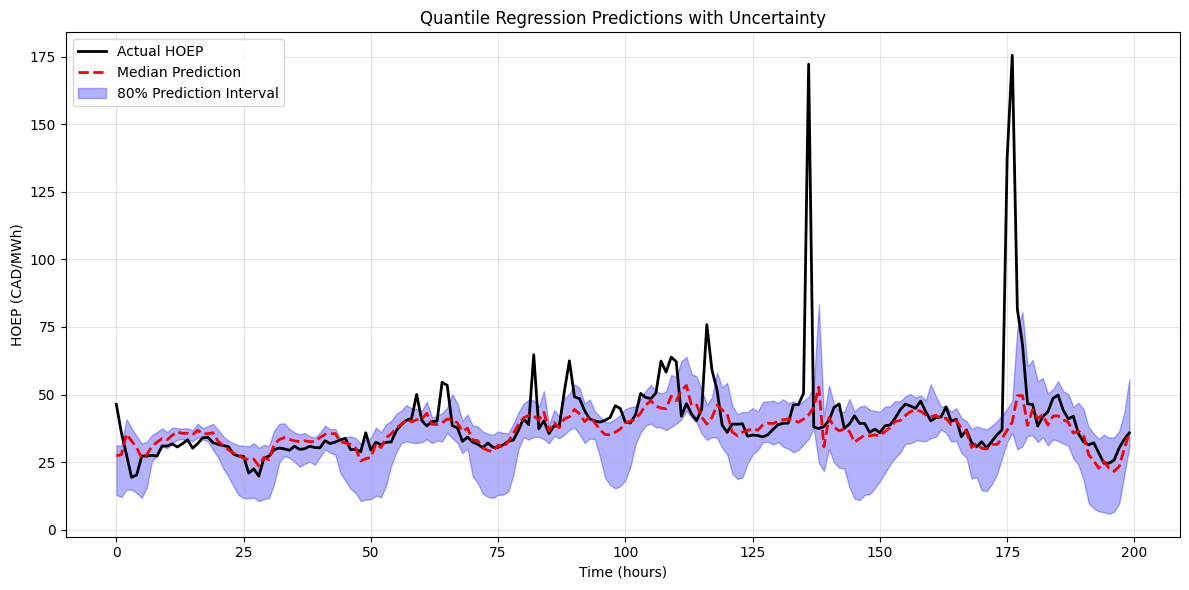

Median quantile RMSE: 33.92


In [ ]:

    
print("Training quantile regression models...")
quantile_predictions = train_quantile_models(X_train, y_train, X_test, y_test, method='separate')
    
print("\nEvaluating quantile predictions...")
results = evaluate_quantile_predictions(y_test, quantile_predictions)
    
print("\n=== Quantile Regression Results ===")
for q_name, metrics in results.items():
    print(f"\nQuantile {q_name}:")
    print(f"  RMSE: {metrics['rmse']:.2f}")
    print(f"  Pinball Loss: {metrics['pinball_loss']:.2f}")
    print(f"  Coverage: {metrics['coverage']:.3f} (expected: {metrics['expected_coverage']:.3f})")
    
# Calculate prediction intervals
intervals = calculate_prediction_intervals(quantile_predictions)
    
print("\n=== Prediction Intervals ===")
for interval_name, interval_data in intervals.items():
    avg_width = np.mean(interval_data['width'])
    print(f"{interval_name} interval average width: {avg_width:.2f} CAD/MWh")
    
# Plot results
plot_quantile_predictions(y_test, quantile_predictions)
    
print(f"Median quantile RMSE: {results['q_50']['rmse']:.2f}")
   


Training XGBoost quantile models...
Training XGBoost quantile 0.1 model...
Training XGBoost quantile 0.5 model...
Training XGBoost quantile 0.9 model...

Evaluating XGBoost quantile predictions...

=== XGBoost Quantile Regression Results ===

Quantile q_10:
  RMSE: 38.12
  Pinball Loss: 1.82
  Coverage: 0.097 (expected: 0.100)

Quantile q_50:
  RMSE: 34.74
  Pinball Loss: 4.99
  Coverage: 0.490 (expected: 0.500)

Quantile q_90:
  RMSE: 37.26
  Pinball Loss: 4.76
  Coverage: 0.865 (expected: 0.900)

=== XGBoost Prediction Intervals ===


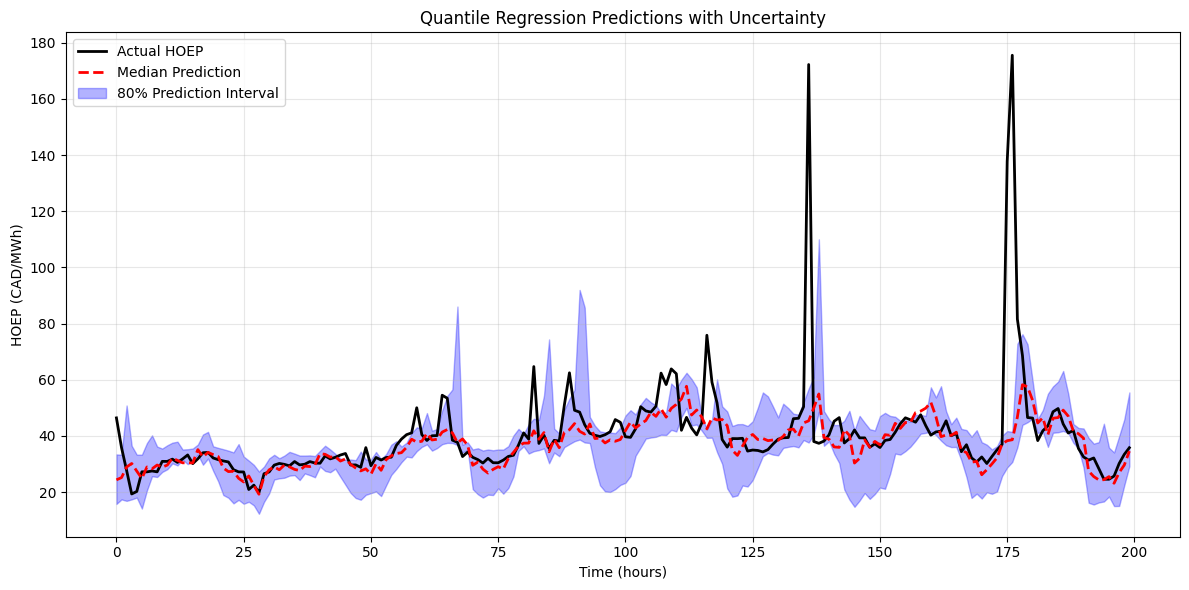


Comparison:
XGBoost q_50 RMSE: 34.74
Neural Network q_50 RMSE: 33.92


In [17]:
import xgboost as xgb

# Reuse your existing quantiles and evaluation functions
# quantiles = [0.1, 0.5, 0.9] (already defined)
# evaluate_quantile_predictions() (already defined)
# calculate_prediction_intervals() (already defined)
# plot_quantile_predictions() (already defined)

def train_xgb_quantile_models(X_train_raw, y_train, X_test_raw, y_test):
    """Train XGBoost quantile models - minimal version for jupyter"""
    
    quantile_predictions = {}
    
    print("Training XGBoost quantile models...")
    
    for q in quantiles:
        print(f"Training XGBoost quantile {q} model...")
        
        # Create XGBoost model for this quantile
        model = xgb.XGBRegressor(
            objective='reg:quantileerror',
            quantile_alpha=q,
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            verbosity=0
        )
        
        # Train on raw data (no scaling needed)
        model.fit(X_train_raw, y_train)
        
        # Make predictions
        quantile_predictions[f'q_{int(q * 100)}'] = model.predict(X_test_raw)
    
    return quantile_predictions

X_train_raw = X_train_raw.values  # Convert DataFrame to numpy
X_test_raw = X_test_raw.values    # Convert DataFrame to numpy
y_train = y_train.values          # Convert Series to numpy  
y_test = y_test.values            # Convert Series to numpy

# Train XGBoost models (use your raw X_train, X_test - not scaled versions)
xgb_predictions = train_xgb_quantile_models(X_train_raw, y_train, X_test_raw, y_test)

# Evaluate using your existing functions
print("\nEvaluating XGBoost quantile predictions...")
xgb_results = evaluate_quantile_predictions(y_test, xgb_predictions)

print("\n=== XGBoost Quantile Regression Results ===")
for q_name, metrics in xgb_results.items():
    print(f"\nQuantile {q_name}:")
    print(f"  RMSE: {metrics['rmse']:.2f}")
    print(f"  Pinball Loss: {metrics['pinball_loss']:.2f}")
    print(f"  Coverage: {metrics['coverage']:.3f} (expected: {metrics['expected_coverage']:.3f})")

# Calculate prediction intervals
xgb_intervals = calculate_prediction_intervals(xgb_predictions)

print("\n=== XGBoost Prediction Intervals ===")
for interval_name, interval_data in xgb_intervals.items():
    avg_width = np.mean(interval_data['width'])
    print(f"{interval_name} interval average width: {avg_width:.2f} CAD/MWh")

# Plot results
plot_quantile_predictions(y_test, xgb_predictions)

print(f"\nComparison:")
print(f"XGBoost q_50 RMSE: {xgb_results['q_50']['rmse']:.2f}")
print(f"Neural Network q_50 RMSE: 33.92")  # Your NN result






In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


class TransformerBlock(tf.keras.layers.Layer):
    """Shallow transformer block with multi-head attention"""
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_quantile_model(input_shape, quantile, embed_dim=64, num_heads=4, ff_dim=128):
    """Create shallow transformer model for single quantile prediction"""
    
    inputs = Input(shape=(input_shape,))
    
    # Initial projection to embedding dimension
    x = Dense(embed_dim)(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    
    # Reshape for transformer (add sequence dimension)
    x = tf.expand_dims(x, axis=1)  # Shape: (batch, 1, embed_dim)
    
    # Shallow transformer block (just one layer)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate=0.2)
    x = transformer_block(x, training=True)
    
    # Global pooling (since we have sequence length of 1)
    x = tf.squeeze(x, axis=1)  # Shape: (batch, embed_dim)
    
    # Final prediction layers
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.001), loss=quantile_loss(quantile))
    
    return model

def create_multi_output_transformer_model(input_shape, quantiles, embed_dim=64, num_heads=4, ff_dim=128):
    """Create transformer model that predicts multiple quantiles simultaneously"""
    
    inputs = Input(shape=(input_shape,))
    
    # Initial projection to embedding dimension
    x = Dense(embed_dim)(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    
    # Reshape for transformer
    x = tf.expand_dims(x, axis=1)
    
    # Shallow transformer block
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate=0.2)
    x = transformer_block(x, training=True)
    
    # Global pooling
    x = tf.squeeze(x, axis=1)
    
    # Final prediction layers
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(len(quantiles))(x)  # One output per quantile
    
    # Custom combined loss for multiple quantiles
    def combined_quantile_loss(y_true, y_pred):
        total_loss = 0
        for i, q in enumerate(quantiles):
            q_pred = y_pred[:, i:i+1]
            error = y_true - q_pred
            total_loss += tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))
        return total_loss
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.001), loss=combined_quantile_loss)
    
    return model

def train_transformer_quantile_models(X_train, y_train, X_test, y_test, method='separate'):
    """
    Train transformer-based quantile regression models
    This is a wrapper that creates transformer models but uses the existing
    train_quantile_models logic where possible
    """
    
    # Ensure y_train is reshaped properly
    if len(y_train.shape) == 1:
        y_train = y_train.reshape(-1, 1)
    
    if method == 'combined':
        # Single model for all quantiles
        print("Training combined transformer model for all quantiles...")
        model = create_multi_output_transformer_model(X_train.shape[1], quantiles)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=100,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1
        )
        
        # Predict all quantiles
        predictions = model.predict(X_test, verbose=0)
        
        # Separate predictions by quantile
        quantile_predictions = {}
        for i, q in enumerate(quantiles):
            quantile_predictions[f'q_{int(q*100)}'] = predictions[:, i]
            
    else:
        # Separate models for each quantile (recommended)
        quantile_models = {}
        quantile_predictions = {}
        
        for q in quantiles:
            print(f"\nTraining transformer model for quantile {q}...")
            
            model = create_transformer_quantile_model(X_train.shape[1], q)
            
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
            history = model.fit(
                X_train, y_train,
                validation_split=0.1,
                epochs=100,
                batch_size=64,
                callbacks=[early_stop],
                verbose=1
            )
            
            # Store model and predictions
            quantile_models[f'q_{int(q*100)}'] = model
            quantile_predictions[f'q_{int(q*100)}'] = model.predict(X_test, verbose=0).flatten()
    
    return quantile_predictions, quantile_models if method == 'separate' else None

# Main execution example
if __name__ == "__main__":
    # Assuming X_train, y_train, X_test, y_test are already prepared as in your code
    # and the original functions (quantile_loss, evaluate_quantile_predictions, 
    # plot_quantile_predictions, calculate_prediction_intervals) are available
    
    # Train transformer models with separate quantiles (recommended)
    print("Training Transformer models for HOEP 1-hour ahead forecasting...")
    quantile_predictions, models = train_transformer_quantile_models(
        X_train, y_train, X_test, y_test, method='separate'
    )
    
    # Use the existing evaluation function
    print("\nEvaluating quantile predictions...")
    evaluation_results = evaluate_quantile_predictions(y_test, quantile_predictions)
    
    # Print evaluation results
    print("\nQuantile Regression Performance:")
    print("-" * 60)
    for q_name, metrics in evaluation_results.items():
        print(f"\n{q_name.upper()}:")
        print(f"  Pinball Loss: {metrics['pinball_loss']:.4f}")
        print(f"  Coverage: {metrics['coverage']:.3f} (Expected: {metrics['expected_coverage']:.3f})")
        print(f"  RMSE: {metrics['rmse']:.4f}")
    
    # Use the existing calculate_prediction_intervals function
    intervals = calculate_prediction_intervals(quantile_predictions)
    if '80%' in intervals:
        print(f"\n80% Prediction Interval Average Width: {np.mean(intervals['80%']['width']):.2f}")
    
    # Use the existing plot function
    plot_quantile_predictions(y_test, quantile_predictions, start_idx=0, end_idx=500)

Training Shallow Transformer quantile models...
Training Transformer quantile 0.1 model...


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")


In [ ]:
for lag in [2, 3]:
    df[f'HOEP_lag_{lag}'] = df['HOEP'].shift(lag)

for lag in [1,2,3]:
    df[f'Demand_lag_{lag}'] = df['Demand'].shift(lag)

features += [f'HOEP_lag_{lag}' for lag in [2, 3]]
features += [f'Demand_lag_{lag}' for lag in [1, 2, 3]]         

df['HOEP_ma_3'] = df['HOEP'].rolling(window=3).mean()
df['Demand_ma_3'] = df['Demand'].rolling(window=3).mean()


features += ['HOEP_ma_3', 'Demand_ma_3']

df = df.dropna()




In [ ]:
X= df[features]
y=df["HOEP"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")


In [ ]:
import os
import pandas as pd

downloads_folder = r'C:\Users\owner\Downloads'
years = range(2002, 2026)  # From 2002 to 2024

dfs = []

for year in years:
    filename = f'PUB_PriceHOEPPredispOR_{year}.csv'
    file_path = os.path.join(downloads_folder, filename)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, skiprows = 3)
        df['Year'] = year 
        dfs.append(df)

    else:
        print(f'File not found: {filename}')

combined_hoep_df = pd.concat(dfs, ignore_index=True)
print(f" Loaded {len(combined_hoep_df)} rows from {len(dfs)} files")        

            






In [ ]:
print(combined_hoep_df.columns)

In [ ]:
import os
import pandas as pd

downloads_folder = r'C:\Users\owner\Downloads'
years = range(2002, 2026)  # From 2002 to 2024
dfs = []

for year in years:
    filename = f'PUB_Demand_{year}.csv'
    file_path = os.path.join(downloads_folder, filename)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, skiprows = 3)
        df['Year'] = year 
        dfs.append(df)

    else:
        print(f'File not found: {filename}')

combined_demand_df = pd.concat(dfs, ignore_index=True)
print(f" Loaded {len(combined_demand_df)} rows from {len(dfs)} files")        

            

print(combined_demand_df.columns)




In [ ]:
import numpy as np
import pandas as pd
combined_hoep_df.columns = combined_hoep_df.columns.str.strip()
combined_demand_df.columns = combined_demand_df.columns.str.strip()

# Build timestamp
combined_hoep_df['Date'] = pd.to_datetime(combined_hoep_df['Date'], format= '%Y-%m-%d')
combined_demand_df['Date'] = pd.to_datetime(combined_demand_df['Date'], format= '%Y-%m-%d')

combined_hoep_df['timestamp'] = combined_hoep_df['Date'] + pd.to_timedelta(combined_hoep_df['Hour']-1, unit = 'h')
combined_demand_df['timestamp'] = combined_demand_df['Date'] + pd.to_timedelta(combined_demand_df['Hour']-1, unit = 'h')

display(combined_demand_df.head()) 
display(combined_hoep_df.head())

combined_hoep_clean = combined_hoep_df[['timestamp','HOEP','Hour 1 Predispatch','OR 10 Min Sync', 'OR 30 Min','Hour']].copy()
combined_demand_clean = combined_demand_df[['timestamp','Ontario Demand']].copy()

# Encode Hour as sin/cos
combined_hoep_clean['hour_sin'] = np.sin(2* np.pi * (combined_hoep_clean['Hour']-1)/24)
combined_hoep_clean['hour_cos'] = np.cos(2 * np.pi * (combined_hoep_clean['Hour'] - 1) / 24)
combined_hoep_clean.drop(columns='Hour', inplace=True)

merged_df = pd.merge(combined_hoep_clean, combined_demand_clean, on= 'timestamp', how= 'inner')

display(merged_df.head())

In [ ]:
# Columns to clean
columns_to_clean = ['HOEP', 'Ontario Demand', 'Hour 1 Predispatch', 'OR 10 Min Sync', 'OR 30 Min']

for col in columns_to_clean:
    merged_df[col] = (
        merged_df[col]
        .astype(str)                # just in case
        .str.replace(',', '')       # remove commas
        .astype(float)              # convert to float
    )

features = []

# Lag features
for lag in [1, 2, 3]:
    merged_df[f'HOEP_lag_{lag}'] = merged_df['HOEP'].shift(lag)
    merged_df[f'Demand_lag_{lag}'] = merged_df['Ontario Demand'].shift(lag)
    features.append(f'HOEP_lag_{lag}')
    features.append(f'Demand_lag_{lag}')

# Rolling means
merged_df['HOEP_ma_3'] = merged_df['HOEP'].rolling(window=3).mean()
merged_df['Demand_ma_3'] = merged_df['Ontario Demand'].rolling(window=3).mean()
features += ['HOEP_ma_3', 'Demand_ma_3']

# Add engineered time features + known inputs
features += [
    'Hour 1 Predispatch',
    'OR 10 Min Sync',
    'OR 30 Min',
    'hour_sin',
    'hour_cos'
]

# Final cleanup
merged_df = merged_df.dropna().reset_index(drop=True)


In [ ]:
display(merged_df.head())
print(merged_df['timestamp'].min(), merged_df['timestamp'].max())
print(len(merged_df))

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X= merged_df[features]
y=merged_df["HOEP"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual HOEP', linewidth=2)
plt.plot(y_pred, label='Predicted HOEP', linewidth=2)
plt.title('Model Prediction vs. Actual (HOEP)')
plt.xlabel('Time Step')
plt.ylabel('HOEP (CAD/MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
